# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Решающие деревья и случайные леса.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 15 баллов
* Задача 2 &mdash; 50 баллов
* Задача 3 &mdash; 30 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import graphviz

Перед выполнением задания обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/trees.html">ноутбук</a> с занятия по решающим деревьям.

---
### Задача 1.

Перед обучением линейной регрессии вы могли совершать некоторые преобразования над признаками. Какие преобразования стоит совершить перед обучением решающего дерева?

В частности, ответьте на вопрос, имеет ли смысл примененять следующие преобразования:
* монотонные функции от одного признака;
* немонотонные функции от одного признака;
* линейные функции от нескольких признаков;
* нелинейные функции от нескольких признаков;
* стандартизация признаков;
* преобразования категориальных признаков.

Пусть $f(x)$ - непрерывная функция, удовлетворяющая указанным свойствам соответственно пунктам. 

Предположим, что мы имеем достаточно большую выборку, которая достаточно точно отражает поведение реальных данных. Тогда теорема из курса математического анализа: Каждое непустое открытое множество $U \subset \mathbb{R}^n$ представимо в виде счетного объединения непересекающихся брусов $B_i = [a_1, b_1]\times ... \times [a_n, b_n],\ a_i\leq b_i \in \mathbb{R} \cup \{\pm \infty\}$.

Утверждение: Если $f:\mathbb{R^n} \rightarrow \mathbb{R}$ - непрерывная функция, то $U_A = \{x \in \mathbb{R}^n\mid f(x) < A\}$ открыто. А занчит с произвольной точностью $\varepsilon$ его можно приблизить брусами. А брус понятно как задается решающим деревом! Значит, при правильной глубине в теории дерево очень точно способно разбить любое множество и без преобразований признаков.

Тем не менее, в жизни данных не всегда достаточно много или они не отражают нужные закономерности (есть выбросы), поэтому преобразования упрощают жизнь и делают оптимальную глубину дерева меньше, тем самым уменьшая шанс переобучиться. Ниже я дам основания, почему некоторые типы преобразований точно не имеют смысла, а какие упрощают жизнь в понимании выше.

**1**. Применение монотонной функции к одному признаку не изменит результаты решающего дерева, так как разделение $x < N$ в дереве без преобразования равносильно $f(x) < f(N)$ в новом дереве.

**2**. Не имеет, так как $f(x) < Const$ разбивает прямую $x$ на участки с чередующейся оценкой (вспомните 9 класс, когда мы решали неравенства от одной переменной). Такие участки легко классифицировать обычным решающим деревом, так как разделение выборки происходит ортогонально признаку $x$. (См. 1)

**3**. Да, имеет. Дерево разбивает вершину по признаку x, паралельно (в геометрическом смысле) остальным признакам. Добавляя линейные комбинации для разбиения вершины, мы получаем возможность разбиения по другим прямым, плоскостям и гиперплоскостям. (См. 2)

Он плохо разделяется горизонтальными оценками, так как на каждую их них влияют и красные, и голубые точки. Но признак x + y < N разделит его практически идеально.

**4**. Нелинейный признаки от нескольких переменных имеет смысл применять. (См 3.)

**5**. Стандартизация признаков суть линейное преобразование, а значит, оно монотонно, поэтому по пункту **1** в нем смысла мало.

**6** Да, так как на словах определен иной порядок, нежели чем на числах. Тем не менее, поскольку категорий обычно конечное число, то дерево сможет отличить одну категорию от другой при достаточной глубине.

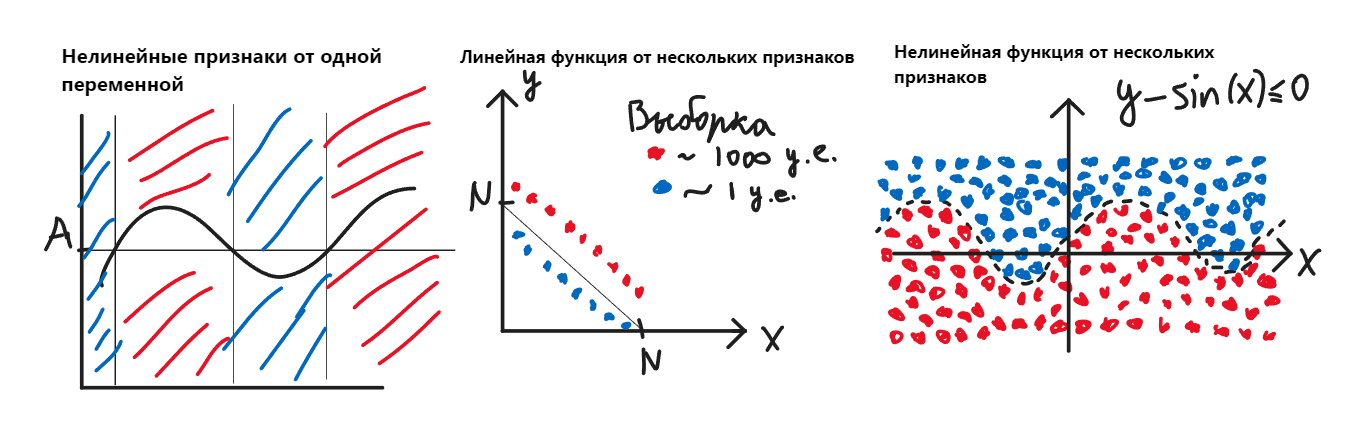

---
### Задача 2.

Рассмотрим данные из <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/task6.html" target="_blank">предыдущего домашнего задания</a>. Скачайте данные и разделите их на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1.

In [112]:
columns = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit',
           'temp', 'atemp', 'hum', 'windspeed', 'cnt']

data = pd.read_csv('bikes.csv')
data = data.loc[:, columns]
X_train, X_val_or_test = train_test_split(data, test_size = 0.4, shuffle = True)
X_train = X_train.reset_index(drop = True)
X_val, X_test = train_test_split(X_val_or_test, test_size = 0.5, shuffle = True)
X_val = X_val.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
X_train.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,4,10,1,1,0,1,0.570833,0.542925,0.733750,0.042304,5117
1,2,4,0,2,1,1,0.446667,0.436233,0.435000,0.249375,5918
2,1,3,0,1,1,1,0.243333,0.241171,0.506250,0.228858,3333
3,3,7,0,0,0,1,0.719167,0.669833,0.604167,0.245033,5302
4,3,7,0,6,0,1,0.738333,0.667308,0.444583,0.115062,5119


Выполните необходимые преобразования признаков

Я предлагаю сохранить категориальные признаки необработанными, так как порядок на них несет в себе дополнительную информацию.

In [113]:
def preprocess_data(X, if_train = True):

    if if_train:
        X = X.drop(index = X[X.holiday == 1].index)

    X = X.drop(columns = ['workingday', 'weathersit', 'holiday'])


    #2 этап
    if if_train:
        q = 0.01
        for feature in ['atemp', 'temp', 'hum', 'windspeed', 'cnt']:
            X = X[(X[feature] < X[feature].quantile(1 - q)) &
                  (X[feature] > X[feature].quantile(q))]

    #3 этап
    Y = X['cnt']
    X = X.drop(columns = ['cnt'])
    return (X, Y)

In [114]:
X_train_pr, Y_train = preprocess_data(X_train)
X_val_pr, Y_val = preprocess_data(X_val, if_train = False)

Обучите решающее дерево глубины 3 и визуализируйте его

In [115]:
depth = 3

model = DecisionTreeRegressor(max_depth = depth,
                              criterion = 'absolute_error')
model = model.fit(X_train_pr, Y_train)

Воспользуемся функцией визуализации дерева с занятия:

In [116]:
def get_graphviz_graph(decision_tree_regressor):
    '''
    Функция для обучения решающего дерева и построения
    по нему графа graphviz для визуализации
    '''
    dot_data = export_graphviz(
        decision_tree_regressor, out_file=None, 
        feature_names=X_train_pr.columns, class_names=Y_train,  
        filled=True, rounded=True, special_characters=True
    )  
    return graphviz.Source(dot_data)

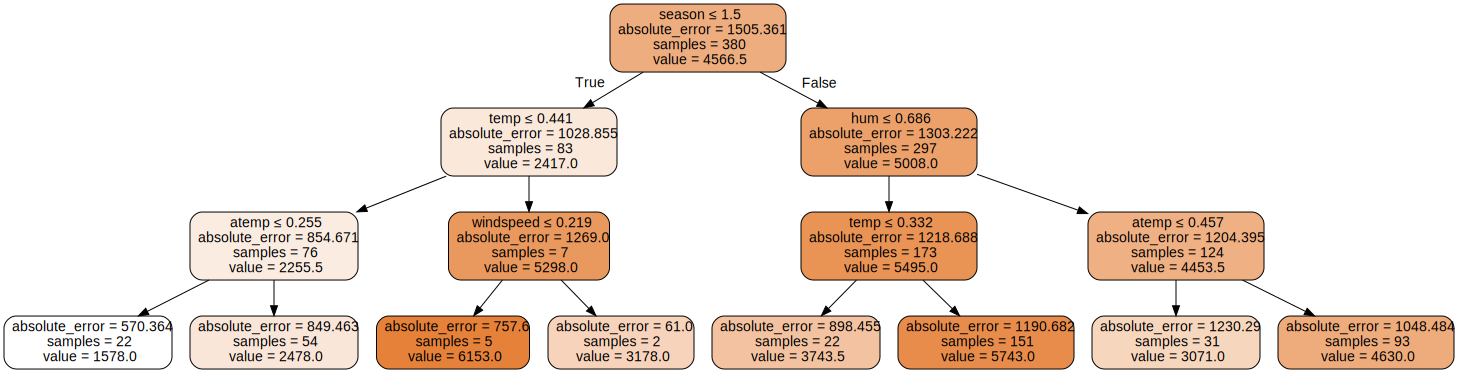

In [117]:
get_graphviz_graph(model)

Подберите оптимальное значение максимальной глубины дерева. Для этого обучите решающие деревья с выставленным значением соответствующего гиперпараметра и посчитайте точность предсказаний каждого из них на валидационной выборке. Постройте соответствующий график.

In [118]:
depths = np.arange(1, 100)

RMSE_val = []
MAE_val = []
MAPE_val = []

for depth in depths:
    model = DecisionTreeRegressor(max_depth = depth,
                                  criterion = 'absolute_error')
    model = model.fit(X_train_pr, Y_train)
    y_pred = model.predict(X_val_pr)
    RMSE_val += [MSE(Y_val, y_pred, squared = False)]
    MAE_val += [MAE(Y_val, y_pred)]
    MAPE_val += [100 * MAPE(Y_val, y_pred)]

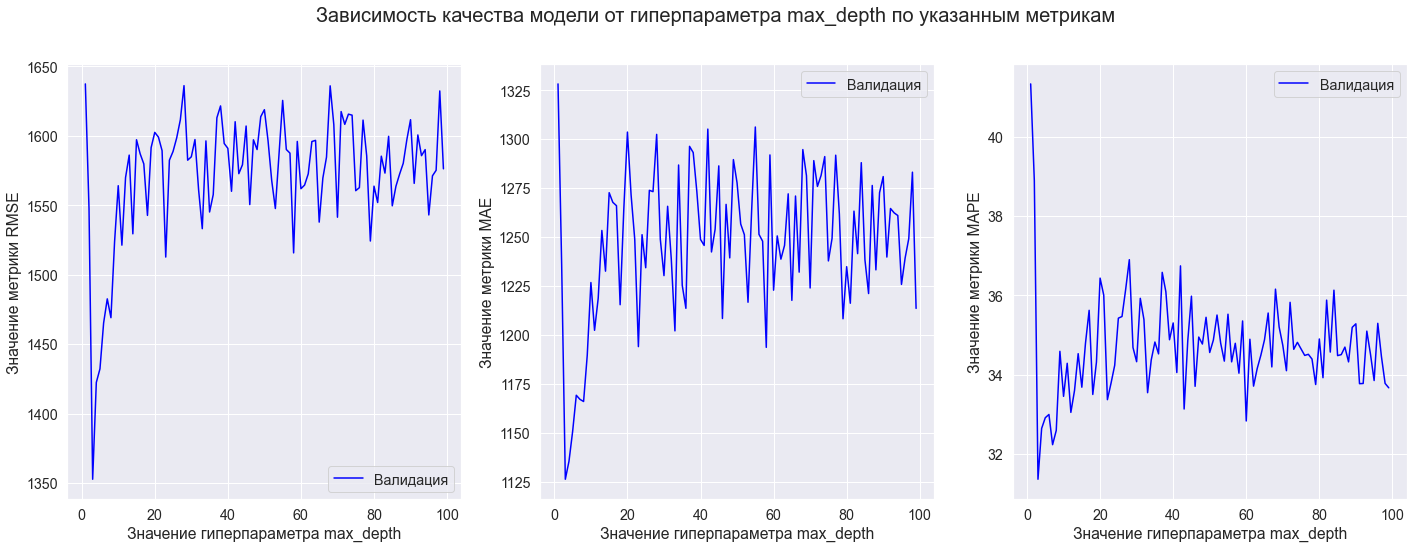

In [119]:
plt.figure(figsize=(24, 8))
with sns.axes_style('darkgrid'):
    plt.suptitle('Зависимость качества модели от гиперпараметра max_depth по ' + 
                'указанным метрикам', fontsize = 20)
    #RMSE
    plt.subplot(131)
    sns.lineplot(x = depths, y = RMSE_val, color = 'blue')
    plt.xlabel('Значение гиперпараметра max_depth')
    plt.ylabel('Значение метрики RMSE')
    plt.legend(['Валидация'])

    #MAE
    plt.subplot(132)
    sns.lineplot(x = depths, y = MAE_val, color = 'blue')
    plt.xlabel('Значение гиперпараметра max_depth')
    plt.ylabel('Значение метрики MAE')
    plt.legend(['Валидация'])
    
    #MAPE
    plt.subplot(133)
    sns.lineplot(x = depths, y = MAPE_val, color = 'blue')
    plt.xlabel('Значение гиперпараметра max_depth')
    plt.ylabel('Значение метрики MAPE')
    plt.legend(['Валидация'])
plt.show()

На графиках мы видим, как модель переобучается при больших значениях гиперпараметра максимальной глубины дерева. Это свзано с тем, что дерево начинает находить зависимости специфические для конкретной обучающей выборки и не отражающих положение вещей в целом.

Как и в предыдущем задании, будем ориентироваться на метрику MAPE, так как она проста и напрямую отражает качество модели.

In [120]:
best_depth = depths[np.argmin(MAPE_val)]
best_depth

3

Аналогичным образом подберите минимальное число объектов в листе, зафиксировав при этом подобранное значение максимальной глубины.

In [121]:
min_samples_leaf = np.arange(1, 100)

RMSE_val = []
MAE_val = []
MAPE_val = []

for N in min_samples_leaf:
    model = DecisionTreeRegressor(max_depth = best_depth, min_samples_leaf = N,
                                  criterion = 'absolute_error')
    model = model.fit(X_train_pr, Y_train)
    y_pred = model.predict(X_val_pr)
    RMSE_val += [MSE(Y_val, y_pred, squared = False)]
    MAE_val += [MAE(Y_val, y_pred)]
    MAPE_val += [MAPE(Y_val, y_pred)]

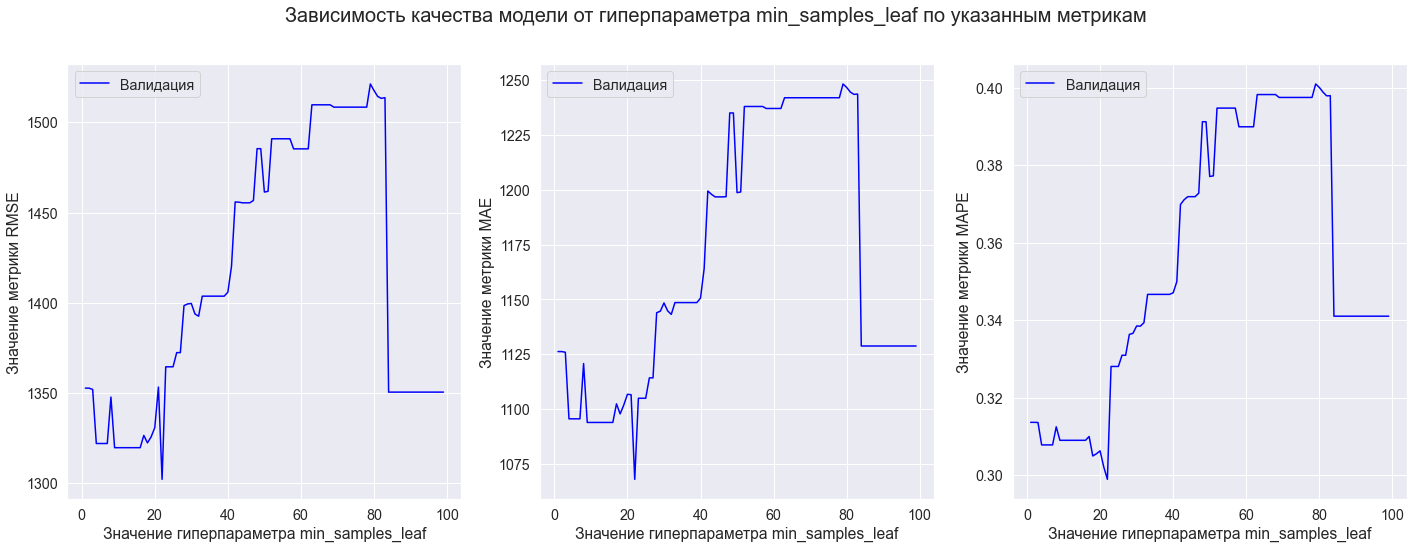

In [122]:
plt.figure(figsize=(24, 8))
with sns.axes_style('darkgrid'):
    plt.suptitle('Зависимость качества модели от гиперпараметра ' +
                 'min_samples_leaf по указанным метрикам', fontsize = 20)
    #RMSE
    plt.subplot(131)
    sns.lineplot(x = min_samples_leaf, y = RMSE_val, color = 'blue')
    plt.xlabel('Значение гиперпараметра min_samples_leaf')
    plt.ylabel('Значение метрики RMSE')
    plt.legend(['Валидация'])

    #MAE
    plt.subplot(132)
    sns.lineplot(x = min_samples_leaf, y = MAE_val, color = 'blue')
    plt.xlabel('Значение гиперпараметра min_samples_leaf')
    plt.ylabel('Значение метрики MAE')
    plt.legend(['Валидация'])
    
    #MAPE
    plt.subplot(133)
    sns.lineplot(x = min_samples_leaf, y = MAPE_val, color = 'blue')
    plt.xlabel('Значение гиперпараметра min_samples_leaf')
    plt.ylabel('Значение метрики MAPE')
    plt.legend(['Валидация'])
plt.show()

Визуализируйте дерево при оптимальных гиперпараметрах и посчитайте его точность на тестовой части выборки.

Посмотрим, при каком количестве объектов в листе вышел наилучший результат:

In [123]:
best_samples = min_samples_leaf[np.argmin(MAPE_val)]
best_samples

22

Обучим модель при лучших гиперпараметрах и визуализируем решающее дерево:

In [124]:
X_test_pr, Y_test = preprocess_data(X_test, if_train = False)

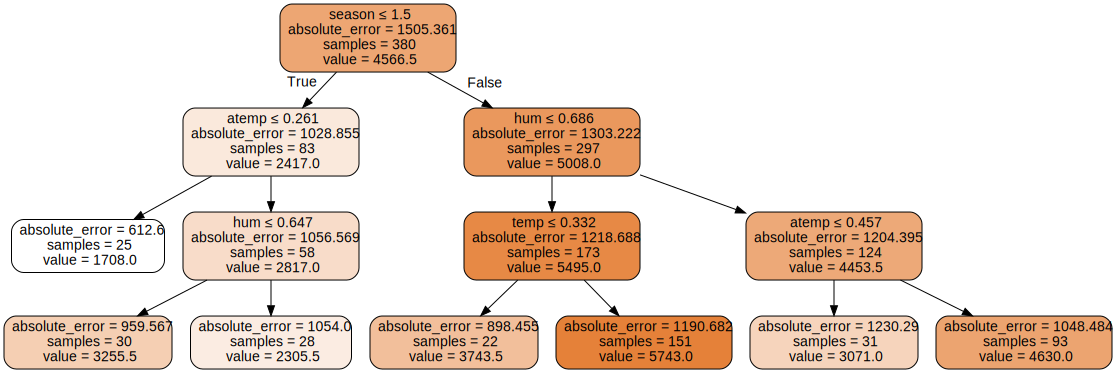

In [125]:
model = DecisionTreeRegressor(max_depth = best_depth,
                              min_samples_leaf = best_samples,
                              criterion = 'absolute_error')
model = model.fit(X_train_pr, Y_train)
get_graphviz_graph(model)

In [126]:
y_pred = model.predict(X_test_pr)

MSE(Y_test, y_pred, squared = False), MAE(Y_test, y_pred),\
100 * MAPE(Y_test, y_pred)

(1489.2193910092035, 1188.5646258503402, 30.195435994932655)

Решающее дерево позволяет оценить *важность признаков* &mdash; некоторая величина, зависящая от того
* насколько часто тот или иной признак использовался при разбиении листа, 
* и насколько сильно при этом изменился критерий информативности.

У обученной модели значения важности признаков лежат в поле `feature_importances_`. Визуализируйте их с помощью `seaborn.barplot`.

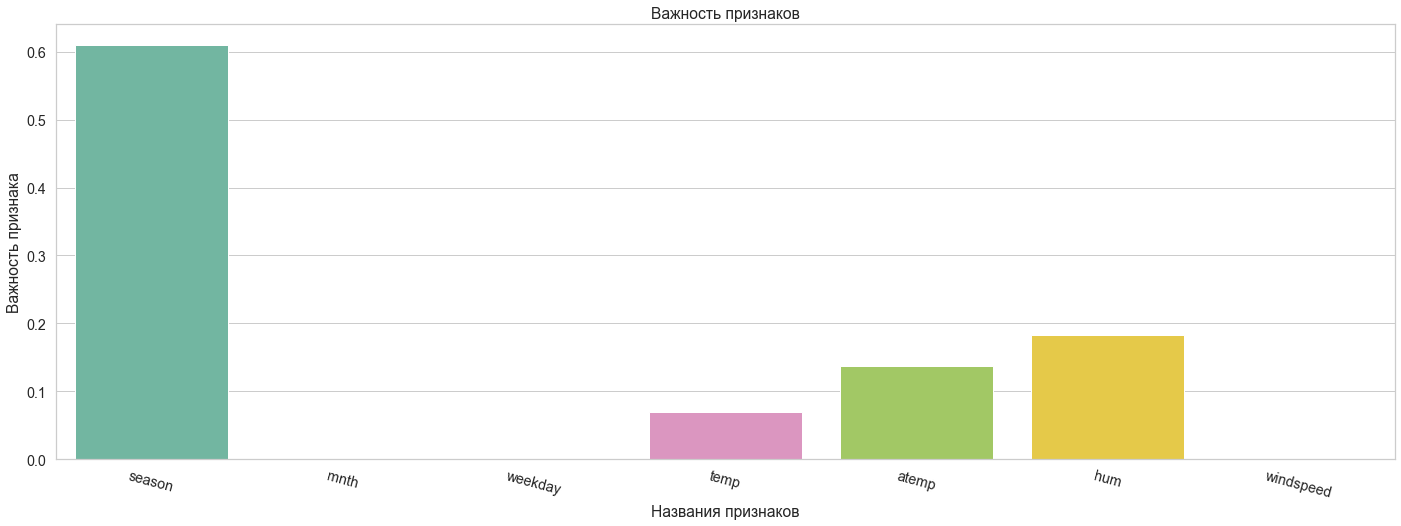

In [127]:
plt.figure(figsize=(24, 8))
with sns.axes_style('whitegrid'):
    sns.barplot(x = model.feature_names_in_, y = model.feature_importances_)
    plt.title('Важность признаков')
    plt.xlabel('Названия признаков')
    plt.ylabel('Важность признака')
    plt.xticks(rotation=-15)
plt.show()

Сделайте выводы.

**Выводы**:

* Решающее дерево при лучших настройках указанных гиперпараметров показало результат, сравнимый с результатом линейной регрессии. 

* Самым информативным признаком является seasons. Численные признаки оказывают меньшее влияние. Категориальные признаки не оказывают влияние вовсе, поскольку глубина дерева очень мала.


---
### Задача 3.

Для данных из предыдущей части обучите случайный лес на 500 деревьев.

In [134]:
rnd_forest = RandomForestRegressor(n_estimators=500,
                                   criterion = 'absolute_error')
rnd_forest = rnd_forest.fit(X_train_pr, Y_train)

Постройте график зависимости точности модели в зависимости от количества деревьев для обучающей и валидационной выборок.

*Замечание.* Не нужно заново обучать лес каждый раз. Используйте у обученной модели поле `estimators_`, это список из объектов класса `DecisionTreeRegressor`.

In [ ]:
train_preds = []
val_preds = []
trees = 500

for i in range(trees):
    next_tree = rnd_forest[i]
    train_preds += [next_tree.predict(X_train_pr)]
    val_preds += [next_tree.predict(X_val_pr)]

train_preds = np.array(train_preds).cumsum(axis = 0)
val_preds = np.array(val_preds).cumsum(axis = 0)

train_preds = train_preds / np.expand_dims(np.arange(1, trees + 1), axis = 1)
val_preds = val_preds / np.expand_dims(np.arange(1, trees + 1), axis = 1);

In [136]:
RMSE_train = []
MAE_train = []
MAPE_train = []
RMSE_val = []
MAE_val = []
MAPE_val = []

for pred in train_preds:
    RMSE_train += [MSE(Y_train, pred, squared=False)]
    MAE_train += [MAE(Y_train, pred)]
    MAPE_train += [100 * MAPE(Y_train, pred)]

for pred in val_preds:
    RMSE_val += [MSE(Y_val, pred, squared=False)]
    MAE_val += [MAE(Y_val, pred)]
    MAPE_val += [100 * MAPE(Y_val, pred)]

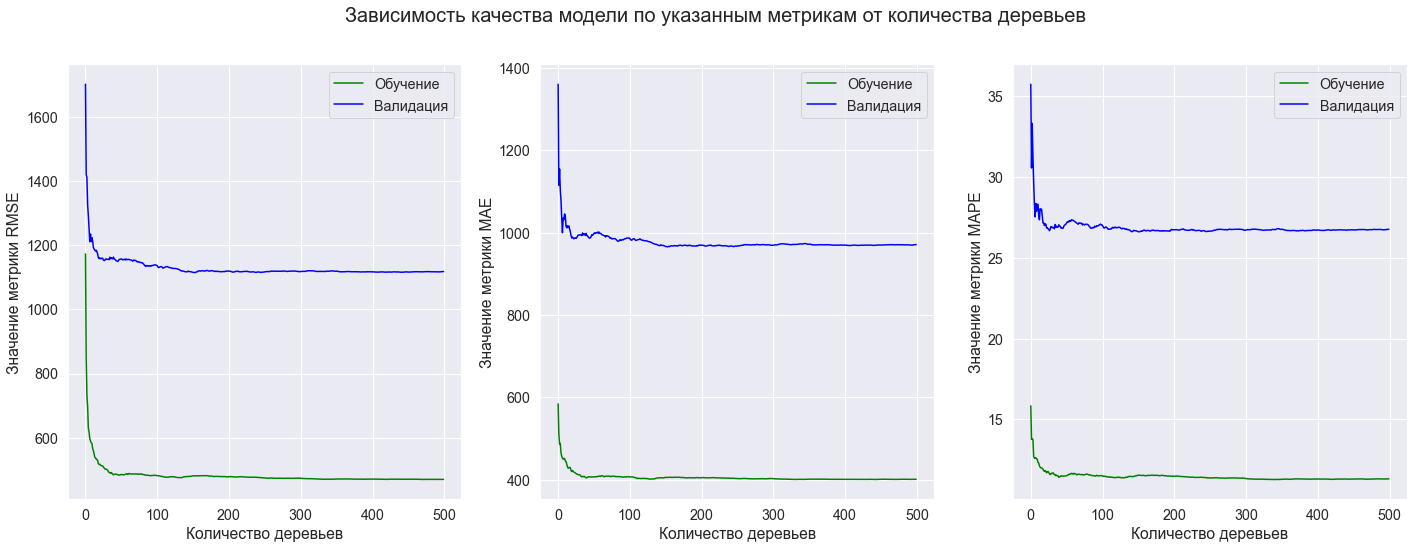

In [137]:
plt.figure(figsize=(24, 8))
with sns.axes_style('darkgrid'):
    plt.suptitle('Зависимость качества модели по указанным метрикам от ' +\
                 'количества деревьев', fontsize = 20)
    #RMSE
    plt.subplot(131)
    sns.lineplot(x = np.arange(trees), y = RMSE_train, color = 'green')
    sns.lineplot(x = np.arange(trees), y = RMSE_val, color = 'blue')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Значение метрики RMSE')
    plt.legend(['Обучение', 'Валидация'])

    #MAE
    plt.subplot(132)
    sns.lineplot(x = np.arange(trees), y = MAE_train, color = 'green')
    sns.lineplot(x = np.arange(trees), y = MAE_val, color = 'blue')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Значение метрики MAE')
    plt.legend(['Обучение', 'Валидация'])
    
    #MAPE
    plt.subplot(133)
    sns.lineplot(x = np.arange(trees), y = MAPE_train, color = 'green')
    sns.lineplot(x = np.arange(trees), y = MAPE_val, color = 'blue')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Значение метрики MAPE')
    plt.legend(['Обучение', 'Валидация'])
plt.show()

Итоговое предсказание на тестовой выборке:

In [138]:
y_pred = rnd_forest.predict(X_test_pr)

MSE(Y_test, y_pred, squared = False), MAE(Y_test, y_pred),\
100 * MAPE(Y_test, y_pred)

(1244.8083605910076, 1077.4157074829932, 29.211516610534883)

Для леса с максимальным количеством деревьев визуализируйте
важность признаков, используя поле `feature_importances_`. 

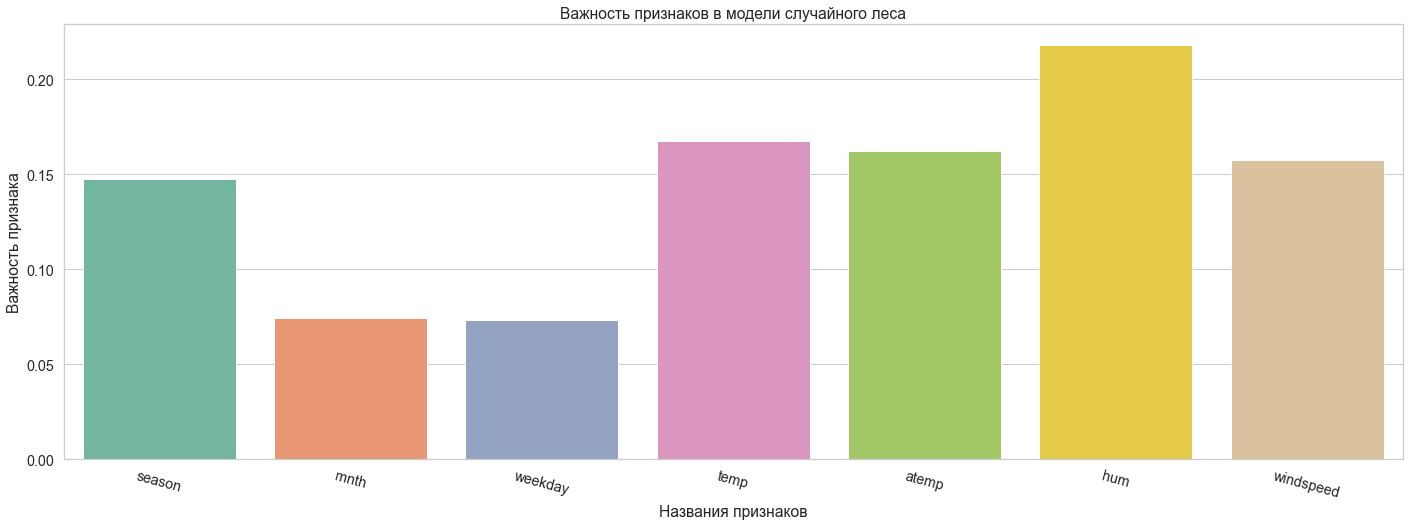

In [139]:
plt.figure(figsize=(24, 8))
with sns.axes_style('whitegrid'):
    sns.barplot(x = rnd_forest.feature_names_in_, 
                y = rnd_forest.feature_importances_)
    plt.title('Важность признаков в модели случайного леса')
    plt.xlabel('Названия признаков')
    plt.ylabel('Важность признака')
    plt.xticks(rotation=-15)
plt.show()

Сделайте выводы.

**Выводы**:

* На первом графике мы видим, что случайные деревья переобучаются на обучающей выборке. Разница между результатами на валидации и обучении очень велика.
* Поскольку деревья случайны, то каждый признак оказывает большее влияние на результат.
* Случайные деревья показали сравнительно хороший результат по предсказанию, чуть лучше по всем метрикам, чем одно решающее дерево с оптимальными гиперпараметрами.